# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

## Подготовка данных

**Загрузка данных**

Установка catboost и lightgbm

In [1]:
pip install catboost

In [2]:
pip install lightgbm

Импорт необходимых библиотек

In [3]:
import pandas as pd

import numpy as np

import math
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedKFold

from sklearn.metrics import mean_squared_error

from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler

from sklearn.pipeline import Pipeline


from catboost import CatBoostRegressor

from lightgbm import LGBMRegressor


import warnings
warnings.filterwarnings('ignore')

Загрузка данных и вывод на экран.

In [4]:
try:  
    data = pd.read_csv('C:/projects/autos.csv')
except OSError as e:
    data = pd.read_csv('/datasets/autos.csv')
display(data.head())
display(data.info())

**Признаки**:
    
- DateCrawled — дата скачивания анкеты из базы
- VehicleType — тип автомобильного кузова
- RegistrationYear — год регистрации автомобиля
- Gearbox — тип коробки передач
- Power — мощность (л. с.)
- Model — модель автомобиля
- Kilometer — пробег (км)
- RegistrationMonth — месяц регистрации автомобиля
- FuelType — тип топлива
- Brand — марка автомобиля
- NotRepaired — была машина в ремонте или нет
- DateCreated — дата создания анкеты
- NumberOfPictures — количество фотографий автомобиля
- PostalCode — почтовый индекс владельца анкеты (пользователя)
- LastSeen — дата последней активности пользователя

<br>

**Целевой признак**

- Price — цена (евро)

**Проверка на наличие NaN и артефактов**

In [5]:
def data_info(data):
    for column in data.columns:
        print('Значения столбца', column)
        print(data[column].sort_values().unique())
        print('Количество NaN:', data[column].isna().sum())

In [6]:
data_info(data)

**Вывод**
<br>
Названия столбцов таблицы необходимо привести к змеиному регистру.
Столбцы с датами привести к типу данным datetype.
<br>

В столбцах присутсвуют NaN:
- VehicleType        316879 non-null  object — тип автомобильного кузова
- Gearbox            334536 non-null  object — тип коробки передач
-  Model              334664 non-null  object  — модель автомобиля
- FuelType           321474 non-null  object — тип топлива
- NotRepaired        283215 non-null  object — была машина в ремонте или нет
<br>

В столбце Price — цена (евро) присутсвуют 0.
<br>

Столбец RegistrationYear — год регистрации автомобиля - иммет аномальные значения 
В столбце и Power — мощность (л. с.) присутсвуют 0 и аномально высокие значения.
Столбец NumberOfPictures содержит одни 0, считаю можно его удалить.


### Предобработка данных

Удаление столбца NumberOfPictures

In [7]:
data = data.drop(columns=['NumberOfPictures'])
data.head(1)

Переименование столбцов

In [8]:
data.columns = data.columns.str.lower()
data.head(1)

In [9]:
data.rename(columns={'datecrawled': 'date_crawled', 'vehicletype': 'vehicle_type',
                   'registrationyear': 'registration_year',
                   'registrationmonth': 'registration_month',
                   'fueltype': 'fuel_type', 'notrepaired' :'not_repaired', 
                   'datecreated': 'date_created', 'postalcode' : 'postal_code',
                   'lastseen' : 'last_seen'
                  }, inplace=True)
data.head(1)

Замена типа данных дата 

In [10]:
data['date_crawled'] = pd.to_datetime(data.date_crawled)
data['date_created'] = pd.to_datetime(data.date_created)
data['last_seen'] = pd.to_datetime(data.last_seen)
data.head(1)

In [11]:
data.info()

Проверка кол-ва нулей в столбце `price`

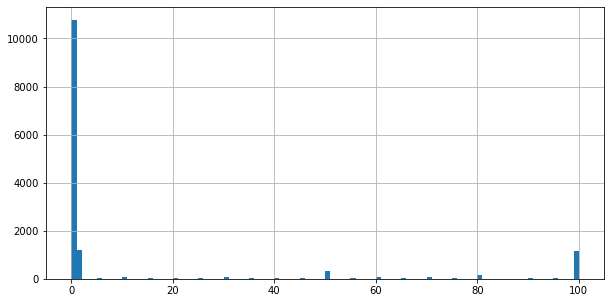

In [12]:
data['price'].hist(bins = 100, figsize=(10,5), range = (0, 100))

Как видно из графика очень много зачений с 0, также считаю, что цена менее 50 евро не явля-ся адекватной, поэтому произведу замену цены менее 50 евро на среднюю цену сформированную по Бренду, Модели и году.

In [13]:
def price(row):
    if row[1] < 50:
        row[1] = np.nan
    return row

In [14]:
data = data.apply(price, axis=1)

In [15]:
data["price"] = data["price"].fillna(data.groupby(['brand', 'model', 'registration_year'])["price"].transform('mean'))
data["price"].isna().sum()

Проверка столбца `RegistrationYear`

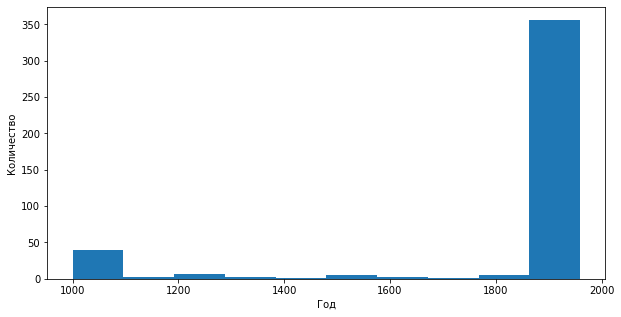

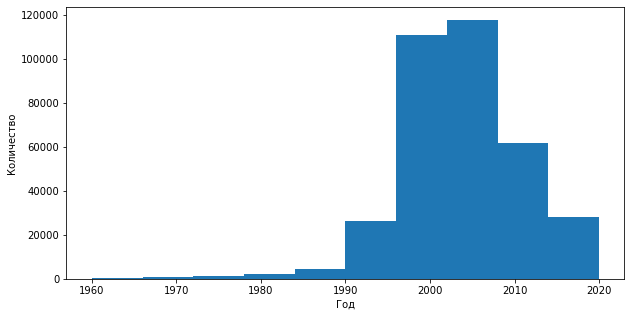

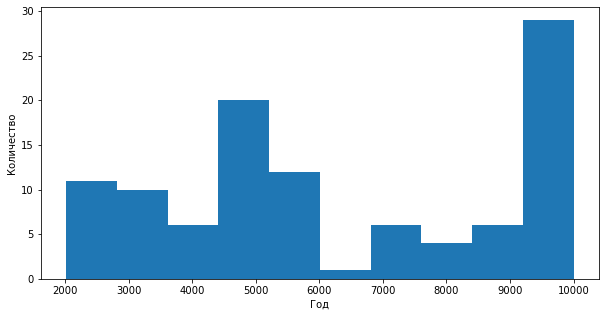

In [16]:
def chart(min, max):
    plt.figure(figsize=(10,5))
    data['registration_year'].plot(kind="hist", range=(min, max));
    plt.xlabel("Год");
    plt.ylabel("Количество");

chart(1000, 1959)
chart(1960, 2020)
chart(2021, 9999)

In [17]:
def year(row):
    if row[3] < 1960:
        row[3] = 1960
    elif row[3] > 2019:
        row[3] = 2019
    return row

In [18]:
data = data.apply(year, axis=1)

In [19]:
data["model"] = data["model"].fillna(data.groupby(['brand', 'registration_year'])["model"].transform('first'))
data["model"].isna().sum()

Проверка столбца `vehicle_type`

In [20]:
data["vehicle_type"] = data["vehicle_type"].fillna(data.groupby(['brand', 'model'])["vehicle_type"].transform('first'))
data["vehicle_type"].isna().sum()

Проверка столбца `price`

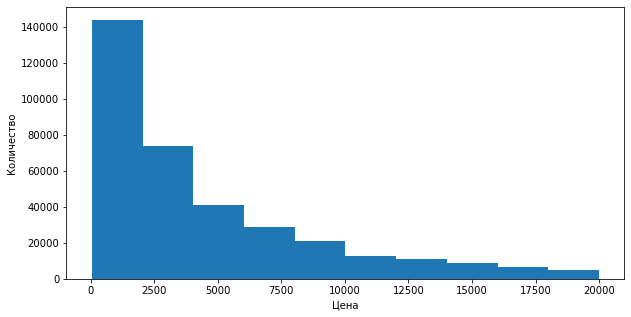

In [21]:
plt.figure(figsize=(10,5))
data['price'].plot(kind="hist");
plt.xlabel("Цена");
plt.ylabel("Количество");

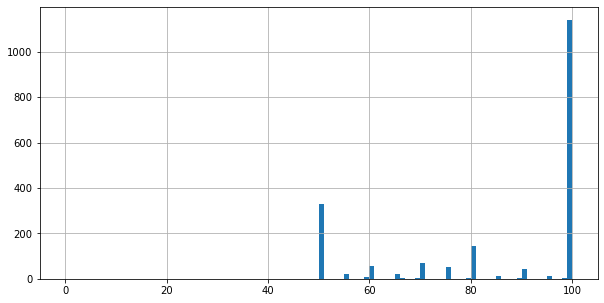

In [22]:
data['price'].hist(bins=100, range = (0, 100), figsize = (10,5));

In [23]:
def price(row):
    if row[1] < 50:
        row[1] = np.nan
    return row

In [24]:
data = data.apply(price, axis=1)

In [25]:
data["price"] = data["price"].fillna(data.groupby(['brand', 'model', 'registration_year'])["price"].transform('mean'))
data["price"].isna().sum()

Проверка столбца `gearbox`

In [26]:
data["gearbox"] = data["gearbox"].fillna(data.groupby(['brand', 'model'])["gearbox"].transform('first'))
data["gearbox"].replace('auto', 1, inplace=True)
data["gearbox"].replace('manual', 0, inplace=True)
data["gearbox"].isna().sum()

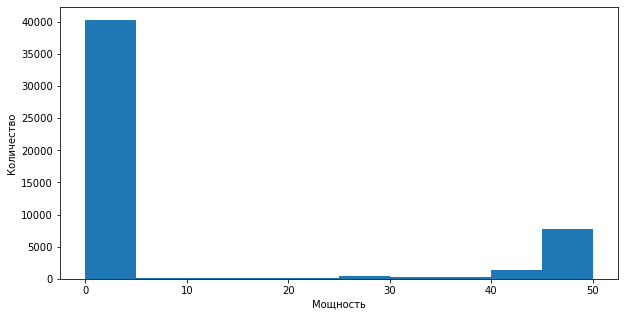

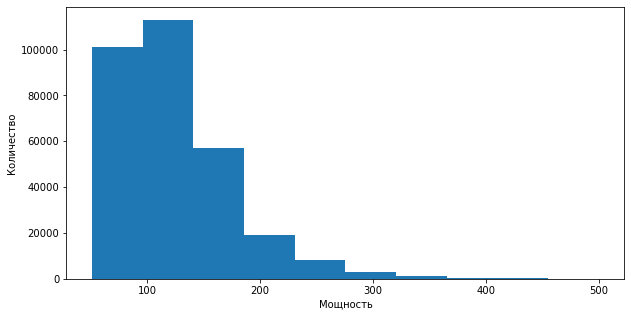

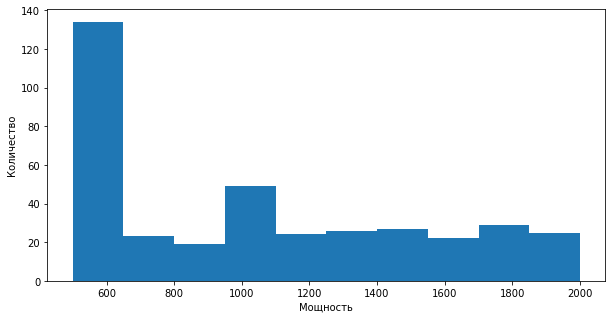

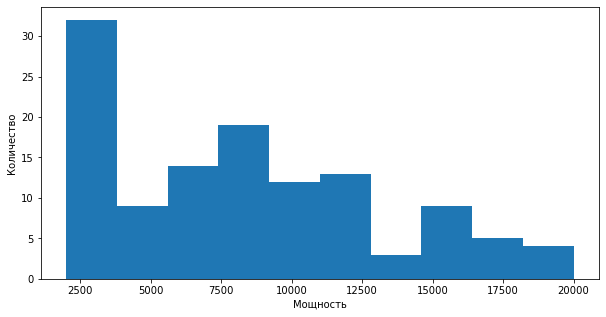

In [27]:
def power(min, max):
    plt.figure(figsize=(10,5))
    data['power'].plot(kind="hist", range=(min, max));
    plt.xlabel("Мощность");
    plt.ylabel("Количество");

power(0, 50)
power(51, 500)
power(500, 2000)
power(2001, 20000)

Найдем машины с высокой мощностью.

In [28]:
top_power = data.query('1600 <= power <= 30000')
top_power.head()

Явная ошибка в данных.

Как видно из графика мощности после 40 л.с наблюдается скачок.

In [29]:
def power(row):
    if row[5] < 40:
        row[5] = np.nan
    elif row[5] > 1600:
        row[5] = np.nan
    return row

In [30]:
data = data.apply(power, axis=1)
data.head()

В столбце `power` произведем возможную замену пропусков по бренду и модели автомобиля.

In [31]:
data["power"] = data["power"].fillna(data.groupby(['brand', 'model'])["power"].transform('mean'))
data["power"].isna().sum()

В столбце `fuel_type` произведем возможную замену пропусков по бренду и модели автомобиля.

In [32]:
data["fuel_type"] = data["fuel_type"].fillna(data.groupby(['brand', 'model'])["fuel_type"].transform('first'))
data["fuel_type"].isna().sum()

В столбце `not_repaired` произведем возможную замену пропусков на 0, т.к. скорее всего пропуски говорят о том, что авто не находилось в ремонте.

In [33]:
data["not_repaired"] = data["not_repaired"].fillna(0)
data["not_repaired"].isna().sum()

Для авто находившихся в ремонте установим значение 1, для остальных 0.

In [34]:
data["not_repaired"].replace('no', 0, inplace=True)
data["not_repaired"].replace('yes', 1, inplace=True)

Удаление дубликатов

In [35]:
data = data.dropna()
data = data.drop_duplicates()
data.info()

Для обучения моделей не понадобятся столбцы `date_crawled` , `date_created`, `last_seen` .

In [36]:
data = data.drop(columns=['date_crawled', 'date_created', 'last_seen'])
data.head()

Отбросим ненужные 0 после  запятой, заменим тип данных float на int в столбцах `price`, `gearbox`, `power`.

In [37]:
data = data.astype({"price": "int64"})
data = data.astype({"gearbox": "int64"})
data = data.astype({"power": "int64"})
data.info()

In [39]:
data = data.drop(columns=['registration_month'])
data.head()

### Вывод
<br>
 
Данные подготовлены, предобработка завершена.

## Обучение моделей

Изучим 4 модели:
- Линейную регрессию
- Ridge
- И модели градиентного бустинга : CatBoost, LightGBM

**Создание выборок**

Замена типа данных на `category`.

In [40]:
data_c = data.astype({"vehicle_type": "category"})
data_c = data_c.astype({"model": "category"})
data_c = data_c.astype({"fuel_type": "category"})
data_c = data_c.astype({"brand": "category"})
data_c.info()

Отделение целевого признака.

In [41]:
target_с = data_c['price']

In [42]:
features_с = data_c.drop('price', axis=1)

Создание тестовой и обучающей выборки

In [43]:
features_с_train, features_с_test, target_с_train, target_с_test = train_test_split(
    features_с, target_с, test_size=0.25, random_state=12345)


print('Размер обучающей выборки', features_с_train.shape[0])
print('Размер тестовой выборки', target_с_test.shape[0])

Для некотегориальных моделей применим метод прямого OHE кодирования.

In [44]:
target = data_c['price']
features = data_c.drop('price', axis=1)

data_ohe = pd.get_dummies(features, drop_first=True)
display(data_ohe.info())


Создание тестовой и обучающей выборки

In [45]:
features_train, features_test, target_train, target_test = train_test_split(
    data_ohe,target, test_size=0.25, random_state=12345)

print('Размер обучающей выборки', features_train.shape[0])
print('Размер тестовой выборки', target_test.shape[0])

### Линейная регрессия

In [59]:
%%time

model_LR = LinearRegression()
scaller = StandardScaler()
pipeline = Pipeline([("standard_scaller", scaller),("linear_regression", model_LR)])
result_LR = (cross_val_score(pipeline,
                                features_train, 
                                target_train,
                                cv=5, 
                                scoring='neg_mean_squared_error').mean() * -1) ** 0.5
print('RMSE =', result_LR)

### Ridge

In [153]:
%%time

model_r = Ridge()
params = [{'solver':['auto', 'svd', 'cholesky', 'lsqr','sparse_cg']}]

result = GridSearchCV(model_r, params, scoring='neg_mean_squared_error', cv=5)
result.fit(features_train, target_train)
print("Best parametrs:", clf.best_params_)
print()
means = result.cv_results_['mean_test_score']
stds = result.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, result.cv_results_['params']):
    print("%0.6f for %r"% ((mean*-1)** 0.5, params))
print()


In [154]:
result_R = (max(means)*-1) ** 0.5
result_R

### CatBoostRegressor

Обучим модель двумя способами.
<br>
1. На данных, закодированных по методу One-hot-encoding.
2. На оригинальных данных с указанием категорий.

Обучение модели на дданых которые были закодированы методом One-hot-encoding.

In [156]:
%%time

model = CatBoostRegressor() 
hyperparams = [{'learning_rate':[0.1, 0.3, 0.5, 0.8],
                'random_state':[12345],
                'verbose':[False]}]

result = GridSearchCV(model, hyperparams, scoring='neg_mean_squared_error')
result.fit(features_train, target_train)
print("Best parameters set:", result.best_params_)
print("Parametrs:")
print()
means = result.cv_results_['mean_test_score']
stds = result.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, result.cv_results_['params']):
    print("%0.6f for %r"% ((mean*-1)** 0.5, params))
print()


Обучение модели на первостепенных данных и с указанием категорий.

In [160]:
%%time

model = CatBoostRegressor(learning_rate=0.3,
                              iterations = 200,
                              random_state=12345, 
                              verbose=False, 
                              cat_features=['vehicle_type','fuel_type','brand','model']) 
result = (cross_val_score(model,
                                features_с_train, 
                                target_с_train, 
                                cv=5, 
                                scoring='neg_mean_squared_error').mean() * -1) ** 0.5
print('RMSE ', result)

In [161]:
result_CBR_2 = (max(means)*-1) ** 0.5
result_CBR_2

### LGBMRegressor

In [162]:
%%time

model = LGBMRegressor(categorical_feature=['vehicle_type','fuel_type','brand','model']) 
params = [{'num_leaves':[20, 100 ,200 ,300], 
                'learning_rate':[0.1, 0.3, 0.5, 0.8],
                'random_state':[12345]}]

result = GridSearchCV(model, params, scoring='neg_mean_squared_error')
result.fit(features_с_train, target_с_train)
print('Best parameters :' , "%0.6f for %r"% ((mean*-1)** 0.5, result.best_params_))

In [163]:
result_LGBMR = (max(means)*-1) ** 0.5
result_LGBMR

### Вывод
<br>
Были изучены 4 модели : Линейная регрессия, Регрессия Ridge, CatBoostRegressor, LGBMRegressor. Для каждой модели выбраны лучшие гиперпараметры и время их выполнения.

## Анализ моделей

Обучение модели с лучшими подобранными гиперапарметрами.

### Линейная регрессия

In [61]:
%%time

model = LinearRegression()
model.fit(features_train, target_train)

CPU times: user 18.4 s, sys: 9.16 s, total: 27.5 s
Wall time: 27.5 s


LinearRegression()

In [47]:
%%time
target_predict = model.predict(features_test)
final_RMSE_LR = mean_squared_error(target_test, target_predict) ** 0.5
final_RMSE_LR

### Ridge

In [48]:
%%time

model = Ridge(solver='svd')
model.fit(features_train, target_train)

In [49]:
%%time
target_predict = model.predict(features_test)
final_RMSE_R = mean_squared_error(target_test, target_predict) ** 0.5
final_RMSE_R

### CatBoostRegressor

In [50]:
%%time

model = CatBoostRegressor(learning_rate=0.3, 
                          random_state=12345, 
                          verbose=False) 
model.fit(features_train, target_train)



In [51]:
%%time

target_predict = model.predict(features_test)
final_RMSE_CBR_ordinal = mean_squared_error(target_test, target_predict) ** 0.5
final_RMSE_CBR_ordinal

In [52]:
%%time

model = CatBoostRegressor(learning_rate=0.3, 
                          iterations = 200, 
                          random_state=12345, 
                          verbose=False,
                          cat_features=['vehicle_type','fuel_type','brand','model']) 
model.fit(features_с_train, target_с_train)


In [53]:
%%time

target_predict = model.predict(features_с_test)
final_RMSE_CBR_original = mean_squared_error(target_с_test, target_predict) ** 0.5
final_RMSE_CBR_original

### LGBMRegressor

In [54]:
%%time

model = LGBMRegressor(learning_rate=0.1, 
                      num_leaves=300, 
                      random_state=12345)
model.fit(features_с_train, target_с_train)

In [55]:
%%time

target_predict = model.predict(features_с_test)
final_RMSE_LGBMR = mean_squared_error(target_с_test, target_predict) ** 0.5
final_RMSE_LGBMR


### Сравнение моделей

In [56]:
final_table= {'Model': ['LinearRegression', 'Ridge', 'CatBoostRegressor One-hot-encoding', 'CatBoostRegressor', 'LGBMRegressor'],
              'RMSE': [2845.076, 2844.835, 1606.264, 1678.364, 1566.876],
             'Training time, second': [10.7, 11.6, 39.3, 41 , 3.9],
             'Prediction time, ms' : [316, 293, 237, 157, 813 ,]} 
 
final_table_data = pd.DataFrame(final_table) 
  
display(final_table_data.sort_values(by='RMSE',ascending=True)) 

### Вывод
<br>

Произведен анализ на тестовой выборке , лучшая модель  LGBMRegressor c временем обучения 3.9 сек и временем предсказания 813 мс , у которой RMSE=1566.876, худшая LinearRegression  с показателем RMSE=2845.076, однако  не самым меделенным временем обучения 10,7 сек. Дольше всего обучалась модель CatBoostRegressor 41 с.


# Итоговый вывод
<br>

В ходе работы было выполнено следующее:

- Были загружены данные, произведена предобработка данных.
- Было обучено 4 модели Линейная регрессия, Ridge, CatBoostRegressor и LGBMRegressor.
- С точки зрения точности предсказания лидером явл-ся LGBMRegressor. Следом за ним идет CatBoostRegressor One-hot-encoding, затем CatBoostRegressor, Ridge, LinearRegression.
- С точки времени обучения лидрует LGBMRegressor 3,9 сек . Дольше всего CatBoostRegressor 41 сек.
- Оптимальной считаю модель LGBMRegressor.